<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/01_basic_sequences/notebooks/FID_for_slides_mz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example FID


In [2]:
!pip show pypulseq &> /dev/null || pip install git+https://github.com/imr-framework/pypulseq.git &> /dev/null
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null

In [3]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


In [4]:
# SETUP
# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=30e-6,
    rf_dead_time=100e-6,
)

# Create a new sequence object
seq = mr.Sequence(system)

# Create 90 degree slice selection pulse and gradient
rf_ex, gz1, _ = mr.make_sinc_pulse(
    flip_angle=90 * np.pi / 180,
    system=system,
    duration=1e-3,
    slice_thickness=5e-3,
    apodization=0.5,
    time_bw_product=4,
    phase_offset=0* np.pi / 180,
    return_gz=True,
)

dwell=10e-6
Nread=128
Nphase=1
print(f"The bandwidth is {1/dwell:.2f} Hz and {1/(dwell*Nread):.2f} Hz/px for the {Nread*dwell*1000:.2f} ms ADC.")

adc = mr.make_adc(
    num_samples=Nread,
    duration=Nread*dwell,
    phase_offset=0* np.pi / 180,
    delay=1e-5,
    system=system,)

The bandwidth is 100000.00 Hz and 781.25 Hz/px for the 1.28 ms ADC.


In [5]:
# CONSTRUCT SEQUENCE
seq.add_block(rf_ex)
seq.add_block(adc)

In [6]:
# check sequence timing
(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

Timing check passed successfully


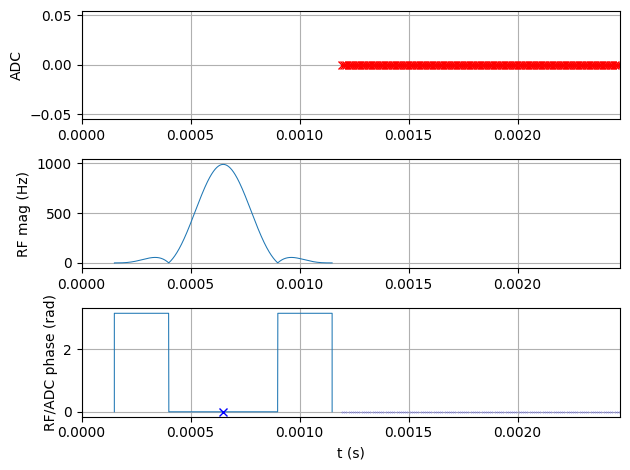

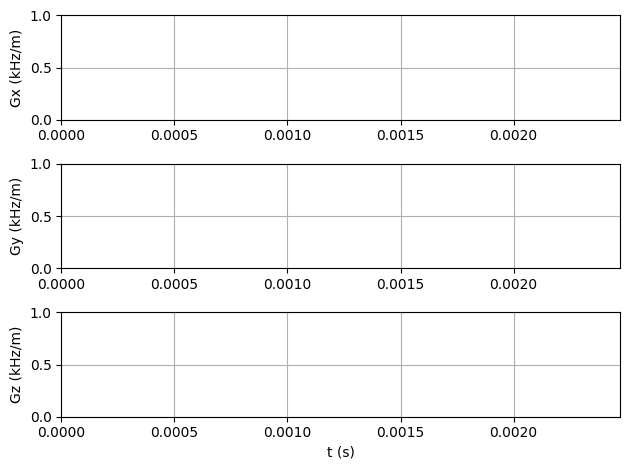

zoom in


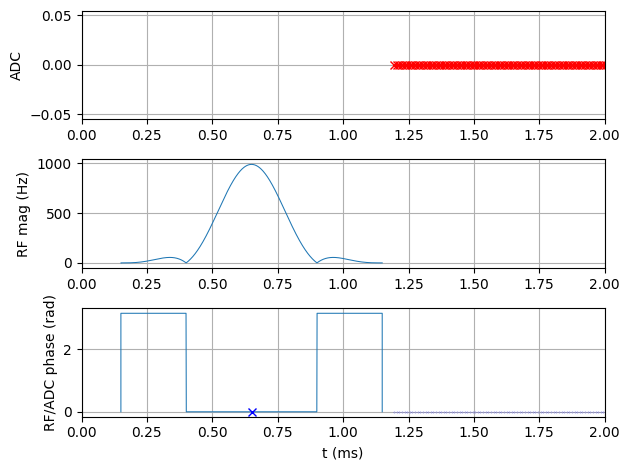

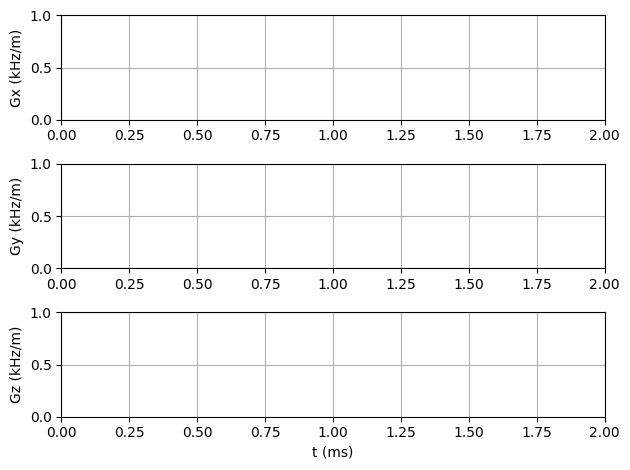

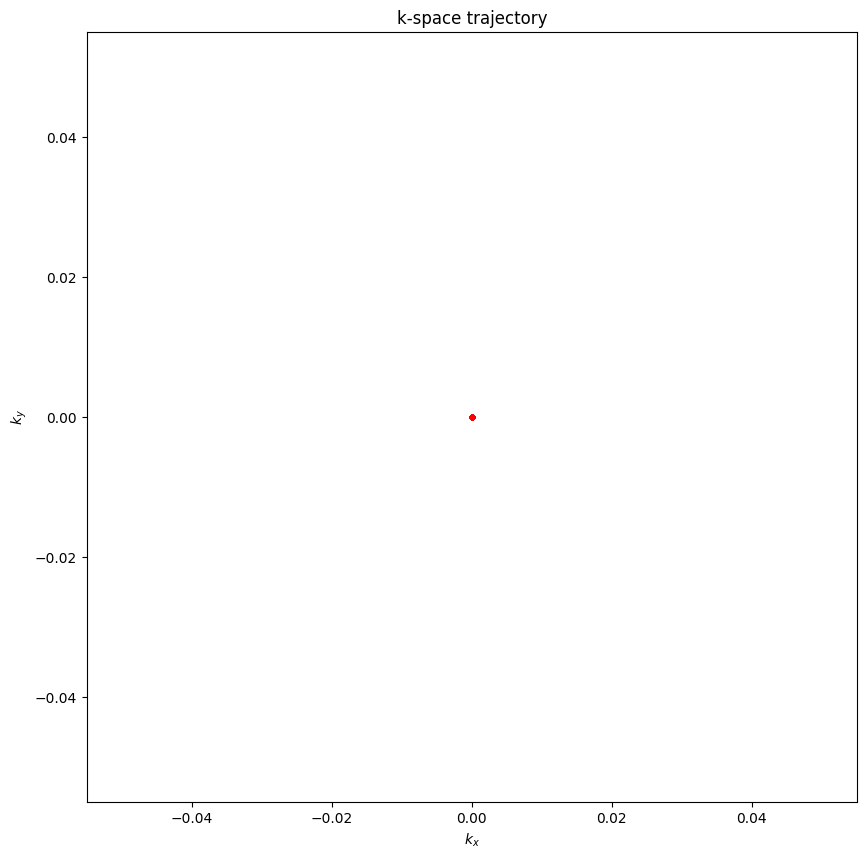

In [7]:
# VISUALIZATION
# plot the entire sequence
seq.plot()


# plot just a small initial part
print('zoom in')
seq.plot(time_range=[0, 0.002], time_disp="ms") #

# plot the k-space trajectory
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace() # TODO: check whether calculate_kspacePP() is better
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca(); ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory'); plt.xlabel('$k_x$'); plt.ylabel('$k_y$')
plt.draw()

In [ ]:
# WRITE .SEQ
seq_filename='FID.seq'
seq.write(seq_filename)
from google.colab import files
files.download(seq_filename)  # Download locally